In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")


In [7]:
# Se serve (una volta sola):
# !pip install -q sentence-transformers scikit-learn matplotlib joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sentence_transformers import SentenceTransformer
#import joblib

SEED = 42
plt.rcParams["figure.dpi"] = 110


c:\Users\DAVIDEPEDRETTI\miniconda3\envs\sbert-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from pymongo import MongoClient
import pandas as pd

MONGO_URI = "mongodb://localhost:27017/"
DB_NAME   = "News"
COLL_NAME = "rawData"     # usa procData (contiene clean/tokens/lemmas)
LABEL_COL = "state"      # oppure "state" se vuoi classificare lo state

client = MongoClient(MONGO_URI)
coll = client[DB_NAME][COLL_NAME]

# Ignoro "Unnamed: 0" direttamente in projection
FIELDS = {
    "_id": 0, "title": 1, "text": 1, "clean": 1,
    "tokens": 1, "lemmas": 1, LABEL_COL: 1
}
docs = list(coll.find({}, FIELDS))
df = pd.DataFrame(docs)

# Filtri minimi
df = df.dropna(subset=[LABEL_COL]).copy()
df[LABEL_COL] = df[LABEL_COL].astype(str)
print(df.shape)
df.head(2)


(44898, 6)


,title,text,state,clean,tokens,lemmas
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1,donald trump just couldn t wish all americans ...,"[donald, trump, wish, americans, happy, new, y...","[donald, trump, wish, american, happy, new, ye..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,house intelligence committee chairman devin nu...,"[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev..."


In [9]:
# Opzioni di modelli di transformers diversi per esigenze diverse 

# MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"        # 384d, molto veloce (CPU ok)
# MODEL_NAME = "BAAI/bge-small-en-v1.5"                        # 384d, piccolo ma moderno
# MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"       # 768d, qualità alta (meglio con GPU)
# MODEL_NAME = "intfloat/e5-base-v2"                           # 768d, moderno (GPU consigliata)
# MODEL_NAME = "BAAI/bge-base-en-v1.5"                         # 768d, moderno (GPU consigliata)


MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # <-- default sicuro

import torch
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
embedder = SentenceTransformer(MODEL_NAME, device=device)

# (Opzionale) limita la lunghezza se i testi sono lunghi:
# embedder.max_seq_length = 256  # 256/384/512: più lungo = più costo, a volte migliore

print(f"Embedding model: {MODEL_NAME} on {device}")


Embedding model: sentence-transformers/all-MiniLM-L6-v2 on cpu


In [10]:
# Embed tutto il dataset in un'unica matrice
X_emb = embedder.encode(
    df["clean"].tolist(),
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

y = df["state"].astype(int).values

print("Shape embedding:", X_emb.shape, " | Target shape:", y.shape)


Batches: 100%|██████████| 351/351 [19:57<00:00,  3.41s/it]


Shape embedding: (44898, 384)  | Target shape: (44898,)


In [11]:
from sklearn.model_selection import train_test_split

X_train_emb, X_test_emb, y_train, y_test = train_test_split(
    X_emb, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train_emb.shape, X_test_emb.shape


((35918, 384), (8980, 384))

In [ ]:
'''
import numpy as np, math

client = MongoClient("mongodb://localhost:27017/")
coll = client["News"]["features_transf"]
coll.delete_many({})

X32 = X_emb.astype(np.float32); y_arr = np.asarray(y)
CHUNK = 2000
for i in range(0, len(y_arr), CHUNK):
    a, b = i, min(i+CHUNK, len(y_arr))
    coll.insert_one({"idx": i//CHUNK, "X": X32[a:b].tolist(), "y": y_arr[a:b].tolist()})
coll.create_index("idx")
print("Done.")
'''

Done.


In [13]:
import numpy as np
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
coll = client["News"]["features_transf"]

X_list, y_list = [], []
for d in coll.find({}, {"_id":0}).sort("idx", 1):
    X_list.extend(d["X"])
    y_list.extend(d["y"])
X_rec = np.array(X_list, dtype=np.float32)
y_rec = np.array(y_list)
print(X_rec.shape, y_rec.shape)

(44898, 384) (44898,)


In [14]:
from sklearn.model_selection import train_test_split

X_train_emb, X_test_emb, y_train, y_test = train_test_split(
    X_emb, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train_emb.shape, X_test_emb.shape

((35918, 384), (8980, 384))

In [15]:
X_train_emb

array([[-0.05373993, -0.01966593,  0.02369131, ..., -0.11858005,
        -0.0891118 , -0.04372675],
       [-0.02469663, -0.01788776,  0.04870337, ..., -0.08258857,
         0.00426046,  0.11564673],
       [ 0.0652147 , -0.02422116,  0.03621315, ..., -0.01041754,
         0.10041754, -0.06307046],
       ...,
       [-0.05759527, -0.00147702, -0.01152975, ..., -0.04982142,
        -0.00213465, -0.04494958],
       [-0.05222053,  0.01802159,  0.02505019, ..., -0.05178549,
        -0.03336233, -0.02565379],
       [ 0.06124287, -0.01602727,  0.08506294, ..., -0.0320912 ,
        -0.049518  ,  0.07359471]], shape=(35918, 384), dtype=float32)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_emb)
X_test_scaled  = scaler.transform(X_test_emb)


In [18]:
models = {
    "LogReg": LogisticRegression(max_iter=2000, random_state=SEED, class_weight="balanced"),
    "LinearSVM": LinearSVC(random_state=SEED, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=SEED),
    "GaussianNB": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=SEED),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


In [19]:
USE_SCALED = True  # True per KNN/NB/Tree/Forest; False ok per SVM/LogReg

Xtr = X_train_scaled if USE_SCALED else X_train_emb
Xte = X_test_scaled  if USE_SCALED else X_test_emb

results, reports, conf_mats = [], {}, {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    results.append({"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1})
    reports[name] = classification_report(y_test, y_pred, digits=3)
    conf_mats[name] = confusion_matrix(y_test, y_pred)

res_df = pd.DataFrame(results).sort_values("f1", ascending=False).reset_index(drop=True)
display(res_df)

for name in res_df["model"]:
    print(f"\n>>> {name} — Classification Report")
    print(reports[name])



=== LogReg ===

=== LinearSVM ===

=== RandomForest ===

=== GaussianNB ===

=== DecisionTree ===

=== KNN ===


,model,accuracy,precision,recall,f1
0,LogReg,0.970045,0.972264,0.970400,0.971331
1,LinearSVM,0.969822,0.972252,0.969974,0.971112
2,RandomForest,0.926615,0.921839,0.939310,0.930493
3,KNN,0.895212,0.932106,0.862436,0.895919
4,GaussianNB,0.869154,0.876900,0.872232,0.874560
5,DecisionTree,0.830401,0.820311,0.865204,0.842160



>>> LogReg — Classification Report
              precision    recall  f1-score   support

           0      0.968     0.970     0.969      4284
           1      0.972     0.970     0.971      4696

    accuracy                          0.970      8980
   macro avg      0.970     0.970     0.970      8980
weighted avg      0.970     0.970     0.970      8980


>>> LinearSVM — Classification Report
              precision    recall  f1-score   support

           0      0.967     0.970     0.968      4284
           1      0.972     0.970     0.971      4696

    accuracy                          0.970      8980
   macro avg      0.970     0.970     0.970      8980
weighted avg      0.970     0.970     0.970      8980


>>> RandomForest — Classification Report
              precision    recall  f1-score   support

           0      0.932     0.913     0.922      4284
           1      0.922     0.939     0.930      4696

    accuracy                          0.927      8980
   macro av

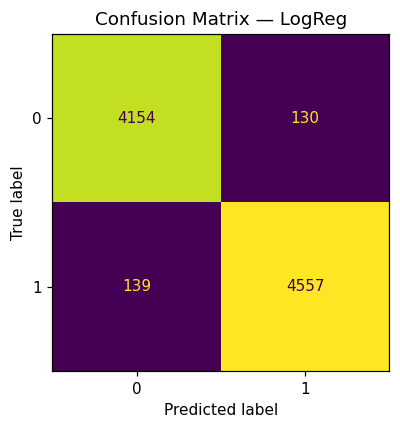

In [20]:
best_name = res_df.iloc[0]["model"]
cm = conf_mats[best_name]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, colorbar=False)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout(); plt.show()


In [22]:
res_df

,model,accuracy,precision,recall,f1
0,LogReg,0.970045,0.972264,0.970400,0.971331
1,LinearSVM,0.969822,0.972252,0.969974,0.971112
2,RandomForest,0.926615,0.921839,0.939310,0.930493
3,KNN,0.895212,0.932106,0.862436,0.895919
4,GaussianNB,0.869154,0.876900,0.872232,0.874560
5,DecisionTree,0.830401,0.820311,0.865204,0.842160
